<a href="https://colab.research.google.com/github/armandordorica/MIE1517_A1/blob/main/MIE1517_Assignment_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Iris Dataset on Google Colab

### Questions

For ## Part 1. Develop a 2-layer ANN [6pt MODEL]
Is my current code 1 or 2 layers?

* Are the analytical and numerical answers close enough?
* Why should we return `layer2` as opposed to the output after the softmax function?
* Does it make sense for the `train_loader` and `val_loader` to be the same size?


Pending items:
* Bonus question
* Do the derivation of the gradient manually.
* Report the times (run the model again).


# PART A: Constructing a Neural Network [8pt]

Before we get into using PyTorch to train our classifier we will go through the process of creating our neural network from scratch. We've seen in the tutorial how to build a 1-layer network, now we'll take it one step further to build a 2-layer network. This is an important exercise that everyone should attempt at least once to understand and truly appreciate the workings of neural networks.


### Helper Functions

To help guide the construction we will use the iris dataset that was introduced in the tutorial. Provided are some helper code to get us started:

In [87]:
# load "Iris_3class.csv" to Google Colab
from google.colab import files
uploaded = files.upload()

Saving Iris_3class.csv to Iris_3class.csv


### Helper Functions

In [94]:

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

def compute_metrics(true_labels, predicted_labels):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    metrics_list = []

    # Deriving metrics for each class
    for i, species in enumerate(true_labels.unique()):
        true_positive = cm[i, i]
        false_positive = sum(cm[:, i]) - true_positive
        false_negative = sum(cm[i, :]) - true_positive
        true_negative = sum(sum(cm)) - true_positive - false_positive - false_negative

        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1_score = 2 * precision * recall / (precision + recall)

        metrics_list.append({
            "Class": species,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1_score
        })

    return pd.DataFrame(metrics_list)


#Convert array to one-hot encoding
def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized


# define sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# derivative of sigmoid
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

# define softmax
def softmax(x):
    e = np.exp(x)
    return e / e.sum(axis=1, keepdims=True)

def ann(W, X_train, y_train):
    num_hidden = 5
    num_features = 4
    num_outputs = 3

    # Weights
    w0 = W[:20].reshape(num_features, num_hidden)
    w1 = W[20:].reshape(num_hidden, num_outputs)

    # Feed forward
    layer0 = X_train
    layer1 = sigmoid(np.dot(layer0, w0))
    layer2 = np.dot(layer1, w1)

    # softmax
    output = softmax(layer2)

    # cross-entropy loss
    m = y_train.shape[0]
    log_likelihood = -np.sum(y_train * np.log(output))
    error = log_likelihood / m

    # Back propagation using gradient descent
    # calculate gradients
    dZ2 = output - y_train
    dw1 = np.dot(layer1.T, dZ2) / m

    dZ1 = np.dot(dZ2, w1.T) * sigmoid_prime(np.dot(layer0, w0))
    dw0 = np.dot(layer0.T, dZ1) / m

    # combine gradients into one vector
    dW = np.concatenate((dw0.flatten(), dw1.flatten()))

    return (error, dW, layer2)


In [95]:


raw_data = pd.read_csv("Iris_3class.csv", header = None)
raw_data = raw_data.values
np.random.shuffle(raw_data)

In [96]:
raw_data.shape

(150, 5)

In [97]:
columns = ['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm', 'species']

# Convert to DataFrame
df = pd.DataFrame(raw_data, columns=columns)

# To see the first few rows of the dataframe
df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species
0,5.0,3.5,1.6,0.6,0.0
1,5.5,2.5,4.0,1.3,1.0
2,4.6,3.6,1.0,0.2,0.0
3,5.5,2.4,3.7,1.0,1.0
4,5.8,2.7,5.1,1.9,2.0


In [108]:
train_df = df.iloc[0:100]

X_train = df.iloc[0:100, :4]
y_train = df.iloc[0:100, 4:5].astype(int)

val_df = df.iloc[100:]
X_val = df.iloc[100:, :4]
y_val = df.iloc[100:, 4:5].astype(int)


In [109]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 4), (100, 1), (50, 4), (50, 1))

Recall that the neural network output consists of several nodes, one for each output class. Since the labels are provided as integers we will need to convert them into one-hot vectors to match the neural network output format.

In [116]:
y_train_one_hot_encoded = pd.DataFrame(to_one_hot(y_train.values))
y_train_one_hot_encoded = y_train_one_hot_encoded.astype(int)


y_val_one_hot_encoded = pd.DataFrame(to_one_hot(y_val.values))
y_val_one_hot_encoded = y_val_one_hot_encoded.astype(int)


y_train_one_hot_encoded.shape, y_val_one_hot_encoded.shape

((100, 3), (50, 3))

## Part 1. Develop a 2-layer ANN [6pt MODEL]
At its core a 2-layer neural network is just a few lines of code. Most of the complexity comes from setting up the training of the network.

Using vectorized form, set up the neural network training to use a cross-entropy loss function and determine the gradients with respect to the layer 1 and layer 2 weights.

In [120]:
num_hidden = 5
num_features = 4
num_outputs = 3

#initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

#combine weights into a single vector
W = np.array(list(w0.flatten()) + list(w1.flatten()))

#train network
n = 0.001
iterations = 100000
errors = []
for i in range(iterations):
  if i%10000==0:
    print(i)
  (error, dW, y_pred) = ann(W, X_train, y_train_one_hot_encoded)
  W += -dW * n
  errors.append(error)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [128]:
#examine predictions on training data
(_, _, y_pred) = ann(W, X_train, y_train_one_hot_encoded)
pred = np.round(y_pred, 0)
pred[:5]

array([[ 2., -0., -3.],
       [-2.,  0.,  0.],
       [ 2., -0., -3.],
       [-1.,  0., -1.],
       [-3.,  0.,  1.]])

In [129]:
train_df['y_pred'] = np.argmax(pred, axis=1)

<ipython-input-129-0fe03d9ac919>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [130]:

(_, _, y_pred_val) = ann(W, X_val, y_val_one_hot_encoded)
y_pred_val = np.round(y_pred_val, 0)

val_df['y_pred'] = np.argmax(y_pred_val, axis=1)

<ipython-input-130-6f26cdb8d9f4>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [131]:
train_df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species,y_pred
0,5.0,3.5,1.6,0.6,0.0,0
1,5.5,2.5,4.0,1.3,1.0,1
2,4.6,3.6,1.0,0.2,0.0,0
3,5.5,2.4,3.7,1.0,1.0,1
4,5.8,2.7,5.1,1.9,2.0,2


In [132]:
val_df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,species,y_pred
100,6.6,2.9,4.6,1.3,1.0,1
101,5.4,3.9,1.7,0.4,0.0,0
102,5.1,3.4,1.5,0.2,0.0,0
103,5.5,3.5,1.3,0.2,0.0,0
104,6.5,2.8,4.6,1.5,1.0,1


## Part 2. Train your neural network [2pt RESULT] - how well model works on iris dataset
How well does your network work on the iris dataset?

The training set performs well but there's a slight overfit on the validation set. We can see that the accuracy goes from >90 for the training set to high 80s on the validation set (look at chart below).

### Measuring performance at predicting each of the classes

* **Iris setosa** (usually coded as 0): This is one of the species of the dataset. It's characterized by its small size compared to the other two species and its distinctively short and wide petals.
* **Iris versicolor** (usually coded as 1): This is the second species of the dataset. It's an intermediate species in terms of petal length and width, lying between the setosa and virginica species in size.
* **Iris virginica** (usually coded as 2): This is the third species of the dataset. It's characterized by its large size compared to the other two species, with long and narrow petals.


In [133]:
# Example usage:
metrics_df = compute_metrics(train_df['species'], train_df['y_pred'])
metrics_df.style.bar(subset = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], align='mid', color=['red', 'lightgreen'])

,Class,Accuracy,Precision,Recall,F1 Score
0,0.000000,0.970000,0.916667,1.000000,0.956522
1,1.000000,0.920000,1.000000,0.741935,0.851852
2,2.000000,0.950000,0.878049,1.000000,0.935065


In [134]:
# Example usage:
metrics_df = compute_metrics(val_df['species'], val_df['y_pred'])
metrics_df.style.bar(subset = ['Accuracy', 'Precision', 'Recall', 'F1 Score'], align='mid', color=['red', 'lightgreen'])


,Class,Accuracy,Precision,Recall,F1 Score
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.000000,0.880000,1.000000,0.684211,0.812500
2,2.000000,0.880000,0.700000,1.000000,0.823529


## Part 3. Validation [2pt MODEL] - verifying gradient computation
Validate that the gradients were computed correctly for the 2-layer neural network you developed.

> The numerical gradient is calculated using the finite difference approximation.
* For each weight `W[ind]`:
  * The weights are perturbed slightly (adding and subtracting a small number `eps`).
  * The network's error is computed for both the perturbed weights (one incremented and the other decremented).
  * The numerical gradient is computed as the difference in errors divided by twice the perturbation (`2*eps`).


> For each weight, the code prints the absolute difference between the numerical gradient and the analytical gradient. If the gradient computations are correct (analytically), this difference should be very small, which is what we observer. The actual numerical and analytical gradients are also printed.

In [135]:
# Write code to numerical verify the gradients you calculated

num_hidden = 5
num_features = 4
num_outputs = 3

# Initialize weights
w0 = 2*np.random.random((num_features, num_hidden)) - 1
w1 = 2*np.random.random((num_hidden, num_outputs)) - 1

# Combine weights
W = np.concatenate((w0.flatten(), w1.flatten()))

# Compute gradients analytically
(error, dW, y_pred) = ann(W, X_train, y_train_one_hot_encoded)

# Compute gradients numerically
dW_num = np.zeros((len(W),1))
eps = 1e-6  # Small constant for numerical gradient computation

for ind in range(len(W)):
  # Reset weights
  We1 = np.array(list(w0.flatten()) + list(w1.flatten()))
  We2 = np.array(list(w0.flatten()) + list(w1.flatten()))

  # Increment/decrement weights slightly
  We1[ind] += eps
  We2[ind] -= eps

  # Compute errors
  (error_e1, dW_e1, y_pred1) = ann(We1, X_train, y_train_one_hot_encoded)
  (error_e2, dW_e2, y_pred2) = ann(We2, X_train, y_train_one_hot_encoded)

  # Obtain numerical gradients
  grad_num = (error_e1 - error_e2) / (2 * eps)

  # Display difference between numerical and analytic gradients
  print(round(abs(grad_num - dW[ind]), 4), grad_num, dW[ind])


0    0.0003
1    0.0008
2    0.0004
dtype: float64 0    0.000772
1   -0.000379
2    0.000040
dtype: float64 0.0004331563195558326
0    0.0267
1    0.2162
2    0.2176
dtype: float64 0   -0.230287
1    0.012690
2    0.014044
dtype: float64 -0.20355331278015587
0    0.0133
1    0.1350
2    0.1564
dtype: float64 0    0.139073
1    0.017347
2   -0.004056
dtype: float64 0.15236464458195528
0    0.0046
1    0.0247
2    0.0202
dtype: float64 0    0.024706
1   -0.004519
2   -0.000052
dtype: float64 0.020134348215373854
0    0.0008
1    0.0096
2    0.0087
dtype: float64 0    0.009522
1   -0.000867
2    0.000073
dtype: float64 0.008728494195479032
0    0.0002
1    0.0005
2    0.0003
dtype: float64 0    0.000527
1   -0.000179
2    0.000018
dtype: float64 0.00036683224280416386
0    0.0125
1    0.1494
2    0.1497
dtype: float64 0   -0.155842
1    0.006115
2    0.006411
dtype: float64 -0.1433170640981134
0    0.0065
1    0.0935
2    0.1036
dtype: float64 0    0.095324
1    0.008311
2   -0.001850
dty

# Part B: Cars and Trucks

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [3]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 9
        label_class = classes[label_index] # ex: 'truck'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cars and trucks, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the car and truck categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [4]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["car", "truck"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:03<00:00, 43562853.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (i) [0.5pt EXPLORATORY]

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

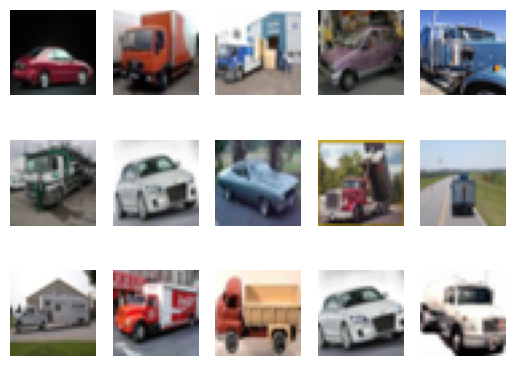

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (ii) [1pt EXPLORATORY]

* How many training examples do we have for the combined `car` and `truck` classes?
* What about validation examples?

In [ ]:
train_loader

In [ ]:

total_training_examples = len(train_loader.dataset)
print("Total training examples for car and truck:", total_training_examples)


Total training examples for car and truck: 50000


In [ ]:
total_validation_examples = len(val_loader.dataset)
print("Total validation examples for car and truck:", total_validation_examples)


Total validation examples for car and truck: 50000


## Part 2. Training

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [5]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
small_net = SmallNet()
large_net = LargeNet()

### Part (i) [1pt EXPLORATORY]

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)


**Given the `SmallNet`**
1. For the convolution layer (`self.conv`):
    - Weights: 3 (input channels) x 5 (output channels) x 3 (kernel height) x 3 (kernel width) = 135
    - Bias: 5 (for each output channel) = 5
    Total = 140

2. For the fully connected layer (`self.fc`):
    - Weights: 5 x 7 x 7 (input features) x 1 (output features) = 245
    - Bias: 1 (for the output feature) = 1
    Total = 246

Summing these together: 140 (from the convolution layer) + 246 (from the fully connected layer) = 386 parameters in total.

So, the `SmallNet` model has 386 parameters in total.

In [8]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


In [9]:
small_net.parameters()

<generator object Module.parameters at 0x783cf366b300>

In [10]:
total_params_small_net = sum(p.numel() for p in small_net.parameters() if p.requires_grad)
total_params_small_net

386

In [11]:
sum(p.numel() for p in small_net.parameters())


386

For the `LargeNet`:

1. **First Convolution Layer (`self.conv1`)**:
    - Weights: \(3 x 5 x 5 x 5\) (input channels x output channels x kernel height x kernel width)
    - Bias: \(5\) (one for each output channel)
    Hence, total parameters for `self.conv1` = \(3 x 5 x 5 x 5 + 5 = 380\)

2. **Second Convolution Layer (`self.conv2`)**:
    - Weights: \(5 x 10 x 5 x 5\)
    - Bias: \(10\)
    Hence, total parameters for `self.conv2` = \(5 x 10 x 5 x 5 + 10 = 1,260\)

3. **First Linear Layer (`self.fc1`)**:
    - Weights: \(10 x 5 x 5 x 32\)
    - Bias: \(32\)
    Hence, total parameters for `self.fc1` = \(10 x 5 x 5 x 32 + 32 = 8,032\)

4. **Second Linear Layer (`self.fc2`)**:
    - Weights: \(32 x 1\)
    - Bias: \(1\)
    Hence, total parameters for `self.fc2` = \(32 x 1 + 1 = 33\)

Pooling layers don't have learnable parameters.

The total number of parameters in `LargeNet` = \(380 + 1,260 + 8,032 + 33 = 9,705\).

So, the `LargeNet` model has 9,705 parameters in total.

In [ ]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
sum(p.numel() for p in large_net.parameters())

9705

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [64]:


def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cars vs trucks
    target_classes = ["car", "truck"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        print("Model Path")
        print(model_path)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    # print("Saving files like {}_train_err.csv".format(model_path))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (ii) [0.5pt EXPLORATORY] - default params of network

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

 `batch_size=64`, `learning_rate=0.01`, `num_epochs=30`

### Part (iii) [0.5pt EXPLORATORY] - files written to disk
What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

There are two main sections where files are written to the disk.


1. The first one is when this happens:

```# Save the current model (checkpoint) to a file
model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
torch.save(net.state_dict(), model_path)
```


The `model_path` is loaded from the `get_model_name` function. Every time the network gets trained (every epoch) a new version of the model will be saved.

2. The second time is when the CSV files are created after training is finished. Four CSV files are saved, which contain the training error, training loss, validation error, and validation loss for each epoch, respectively.


```python
np.savetxt("{}_train_err.csv".format(model_path), train_err)
np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
np.savetxt("{}_val_err.csv".format(model_path), val_err)
np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
```

### Part (iv) [0.5pt EXPLORATORY] - train small and large net
Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in the parts that follow.
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [13]:
from google.colab import drive
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1'

Mounted at /content/drive


Testing a txt file to save to that Google Drive folder

In [14]:
import os
with open(os.path.join(folder_path, 'myfile.txt'), 'w') as f:
    f.write('Hello, Google Drive!')


In [15]:
import os
folder_path = '/content/drive/MyDrive/u of t/PhD/2023/MIE 1517 - Deep Learning/Assignments/A1'
os.chdir(folder_path)

In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: ignored

In [ ]:
train_net(large_net, batch_size=64, learning_rate=0.01, num_epochs=30)

> The `large_net` has more layers and more units than the `small_net` so,  everything else being constant, the `large_net` should take longer to train as it has more parameters to be updated and requires more computation for each iteration, so it generally requires longer to train.

### Part (v) [0.5pt EXPLORATORY] - plot training curve function
Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

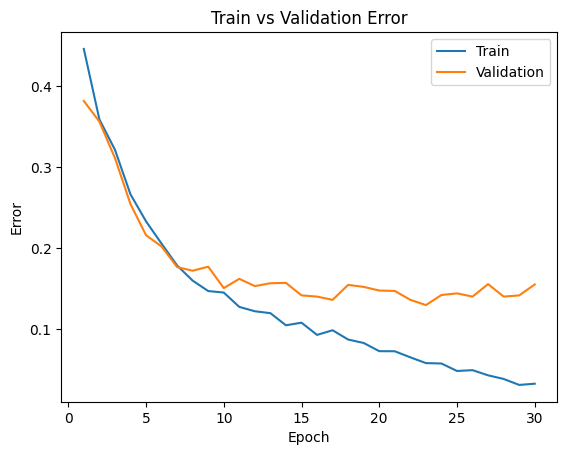

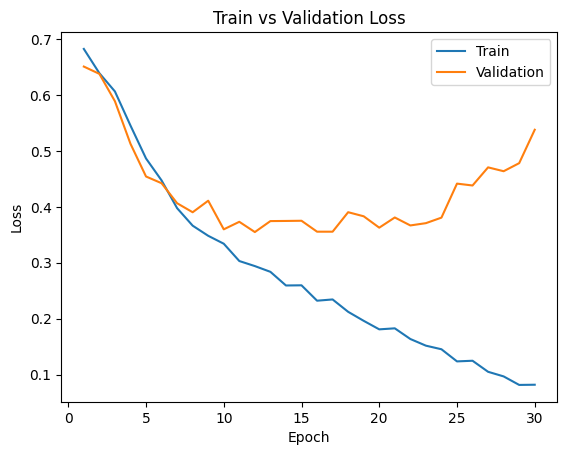

In [16]:
plot_training_curve('model_large_bs64_lr0.01_epoch29')

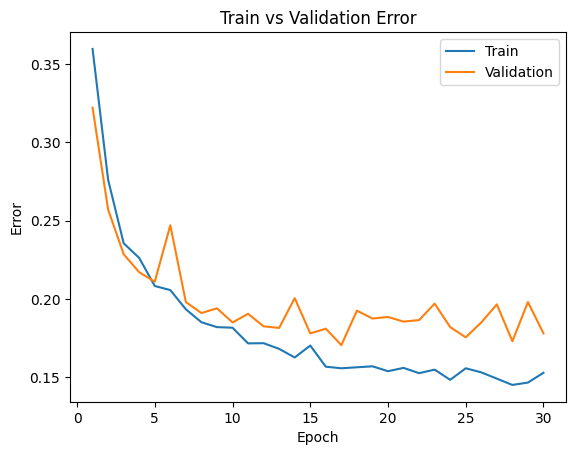

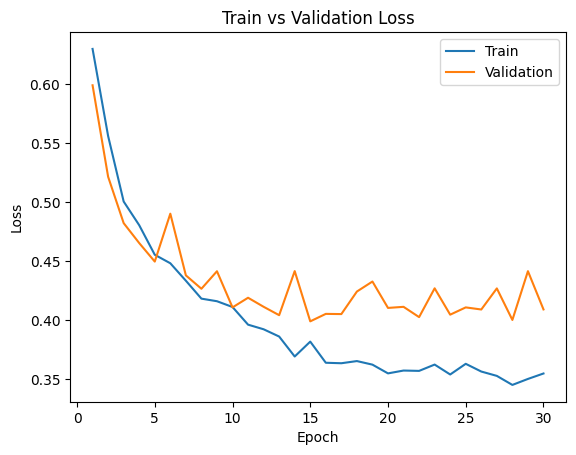

In [17]:
plot_training_curve('model_small_bs64_lr0.01_epoch29')

In [18]:
get_model_name(small_net.name, 64, 0.01, 30)

'model_small_bs64_lr0.01_epoch30'

### Part (vi) [0.5pt EXPLORATORY]
Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

> **Small net** seems to be fine, slightly overfitted if anything. However, the **Large net** is clearly overfitting as we see that the loss function increases for the validation set at some epoch even though the training loss keeps decreasing.

## Part 3. Optimization Parameters

For this section, we will work with `large_net` only.

### Part (i) [0.5pt EXPLORATORY] - training time vs lower learning rate
Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

### Note: When we re-construct the model, we start the training with *random weights*. If we omit this code, the values of the weights will still be the previously trained values.


In [19]:
large_net = LargeNet()

In [20]:
large_net

LargeNet(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=250, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)

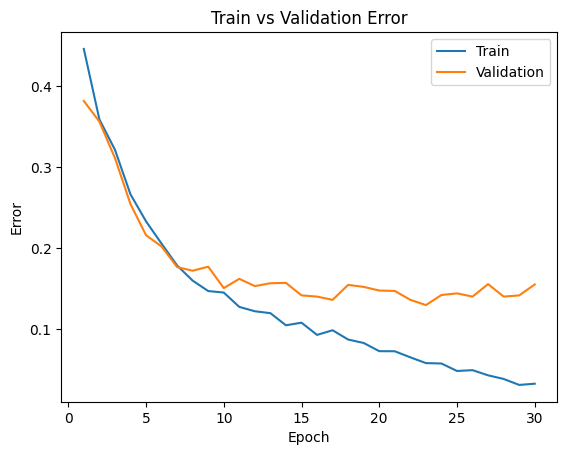

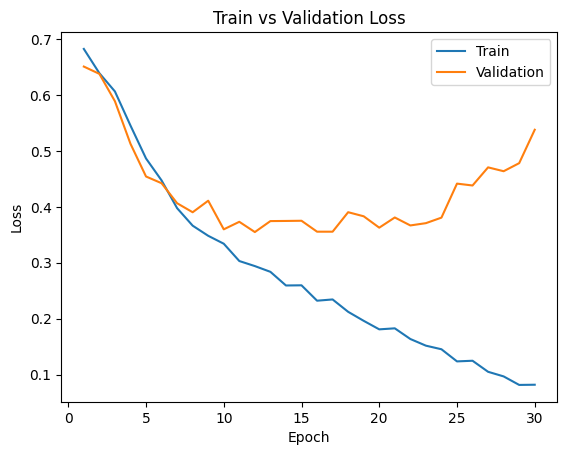

In [21]:
plot_training_curve('model_large_bs64_lr0.01_epoch29')

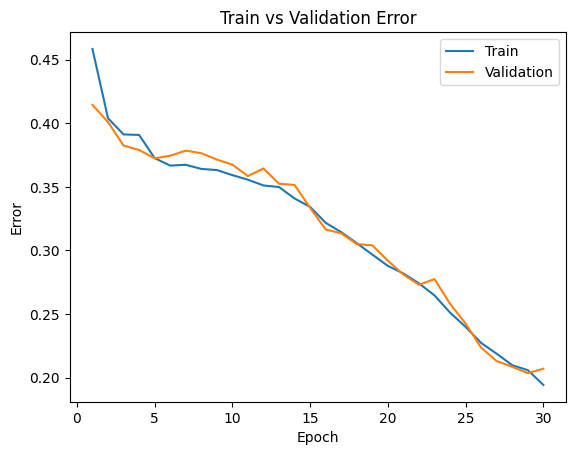

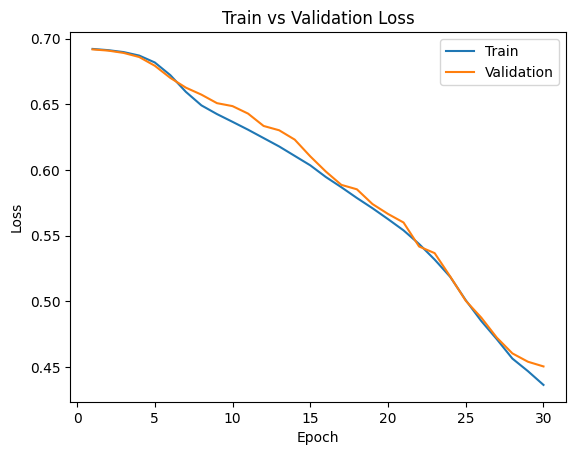

In [22]:
plot_training_curve('model_large_bs64_lr0.001_epoch29')

If we look at the y axes of both loss and error, we see that `0.001` is more optimal than `0.01` as both the error and the loss are lower. In addition, the training and validation sets are less away from each other. A lower learning rate leads to a slower but surer convergence.

Not that the **time taken per epoch when training a neural network is primarily a function of factors such as the number of operations performed, the batch size, the architecture of the network, data loading times, etc. The learning rate itself doesn't directly affect the computational operations required in an epoch. Therefore, we wouldn't expect a change in learning rate to directly affect the time taken for each epoch.**

However, there might be some indirect effects to consider:

* Convergence Behavior: With a larger learning rate, the model may oscillate more and take longer to converge. However, since we've fixed the number of epochs to 30 in both cases, this wouldn't affect the training time in this specific example.
* Numerical Precision and Stability: Extremely small or large learning rates might cause numerical issues (like vanishing or exploding gradients), which could, in theory, slightly affect computation times. But **the difference between 0.01 and 0.001 isn't drastic enough to expect this to be a major concern.**
* Other factors like random initializations, slight variations in data loading or processing times, other processes running on the machine, etc., can introduce variations in training time.

In your case, the difference in elapsed times is relatively small (136.28s for 0.01 vs  135.44 seconds and 0.001). This difference is likely due to the aforementioned factors, including small random variations. It's not due to the change in learning rate itself.

If one were to run the training multiple times, one might find that the times vary slightly with each run, even with the same parameters. It's essential to ensure that other conditions (like system load, initializations, etc.) are consistent if we're trying to perform precise benchmarks or comparisons.

### Part (ii) [0.5pt EXPLORATORY] - effect of increasing learning rate
Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

> Increasing the learning rate speeds up the initial learning but can lead to instability, potential divergence, and poor generalization on unseen data.

> **Convergence Speed:** A higher learning rate (like 0.1) leads to a faster initial decrease in error compared to the lower rates. However, it's important to note that faster isn't always better. The rapid changes can lead to overshooting the optimal point.

> **Stability:**
With a high learning rate (0.1), the training process becomes less stable. This is evident from the oscillations in error and, by the end of 30 epochs, a notable increase in error, indicating divergence.
A medium learning rate (0.01) shows more stable behavior than the highest rate and manages to reduce error consistently.
The lowest learning rate (0.001) is the most stable, with a slow and steady reduction in error.

> **Overfitting:**
A higher learning rate, like 0.1 in this context, doesn't show a clear sign of overfitting, but that's because it diverges before it even has the chance to overfit.
A medium rate (0.01) begins to show signs of overfitting in the later epochs as the training error continues to decrease while the validation error starts to rise.
The lowest rate (0.001) doesn't show significant signs of overfitting within the 30 epochs, but the model is learning very slowly.

> **Generalization on Validation Data:**
A high learning rate (0.1) performs poorly on the validation set after the initial few epochs, which suggests that the model isn't generalizing well due to the instability introduced by the high rate.
Medium (0.01) and low (0.001) learning rates perform better in terms of generalization, with the medium rate being more effective within the 30 epochs.
In summary, based on this context:


Increasing the learning rate speeds up the initial learning but can lead to instability, potential divergence, and poor generalization on unseen data.
While a higher learning rate can achieve faster convergence, it comes with the risk of overshooting the optimal solution and can even cause divergence in the worst-case scenario.

Finding the right learning rate is a balancing act between speeding up convergence and ensuring stability and generalization. Too high can be unstable, while too low might be too conservative and slow.





In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)

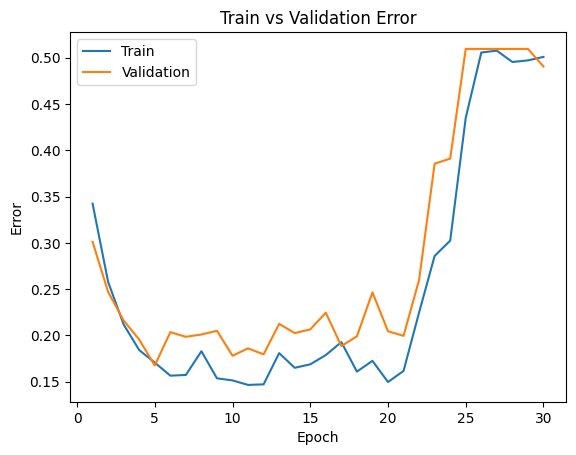

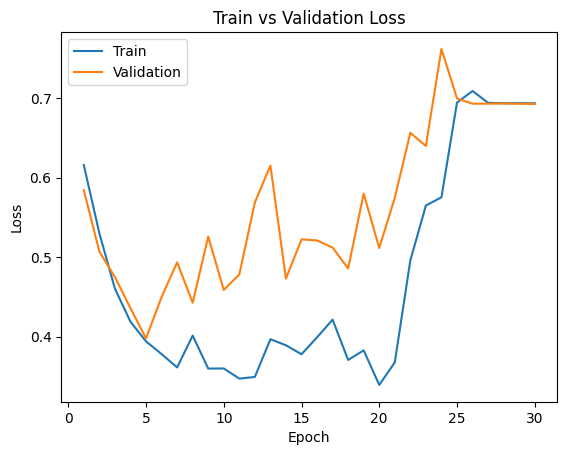

In [23]:
plot_training_curve('model_large_bs64_lr0.1_epoch29')

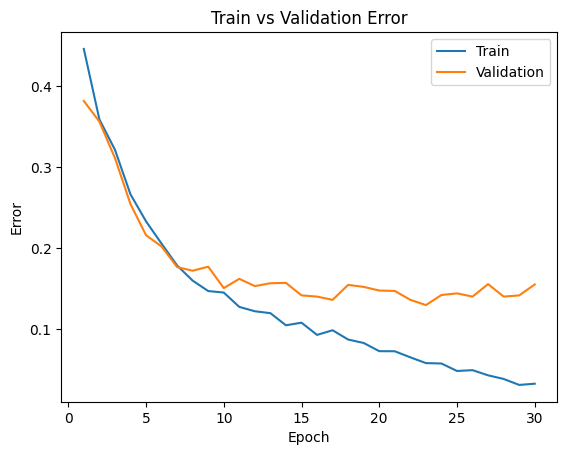

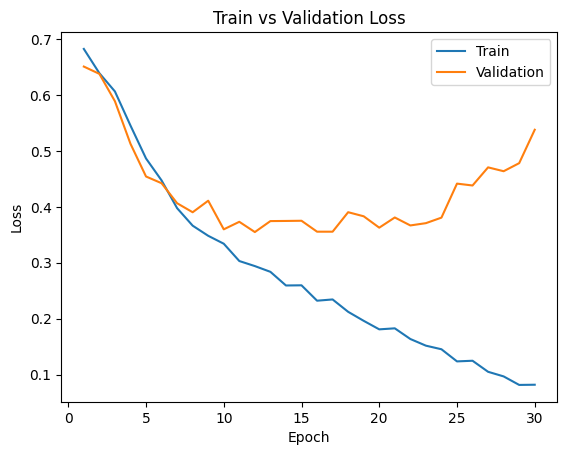

In [24]:
plot_training_curve('model_large_bs64_lr0.01_epoch29')

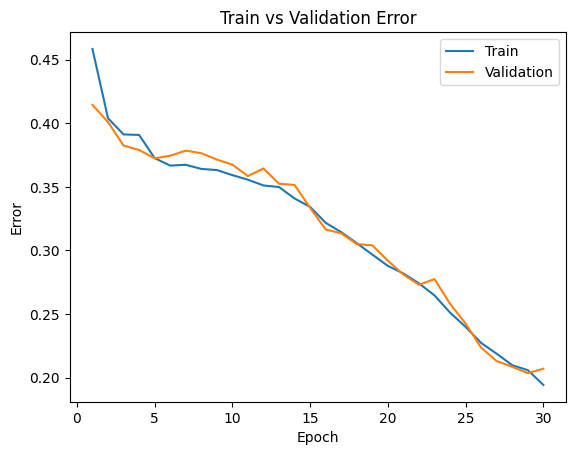

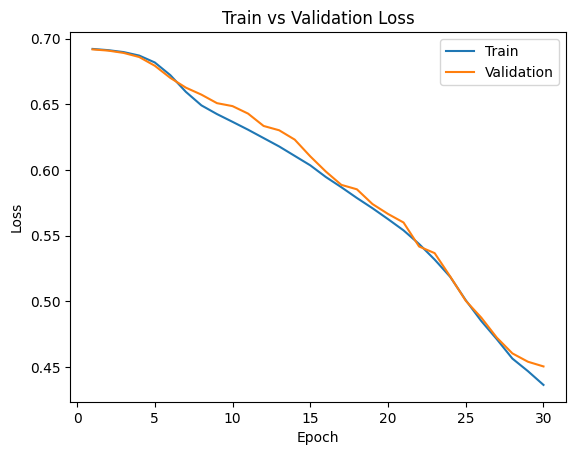

In [25]:
plot_training_curve('model_large_bs64_lr0.001_epoch29')

Train Error for LR=0.1: [0.342375 0.25775  0.21175  0.184125 0.170625 0.1565   0.15725  0.182875
 0.153625 0.151375 0.1465   0.147125 0.180875 0.165    0.16875  0.17875
 0.19275  0.160875 0.1725   0.149625 0.161625 0.22475  0.285875 0.302375
 0.435125 0.505625 0.507625 0.495375 0.497125 0.500875]
Validation Error for LR=0.1: [0.301  0.247  0.216  0.1955 0.1675 0.2035 0.1985 0.201  0.205  0.178
 0.186  0.1795 0.2125 0.2025 0.2065 0.2245 0.1885 0.199  0.2465 0.2045
 0.1995 0.26   0.3855 0.391  0.5095 0.5095 0.5095 0.5095 0.5095 0.4905]
Train Error for LR=0.01: [0.446375 0.35925  0.32175  0.2665   0.233125 0.2055   0.1785   0.15975
 0.146875 0.145    0.12725  0.121875 0.1195   0.1045   0.10775  0.092625
 0.098375 0.086875 0.082625 0.0725   0.072375 0.064875 0.05775  0.05725
 0.048    0.049    0.042625 0.038125 0.03075  0.03225 ]
Validation Error for LR=0.01: [0.382  0.3565 0.3115 0.2545 0.216  0.202  0.1765 0.172  0.177  0.1505
 0.162  0.153  0.1565 0.157  0.1415 0.14   0.136  0.1545 0.15

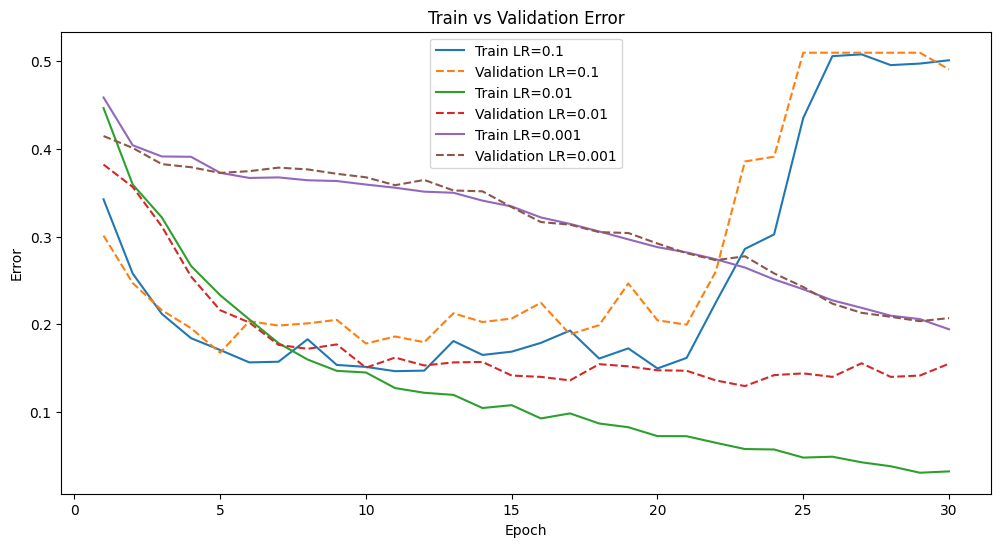

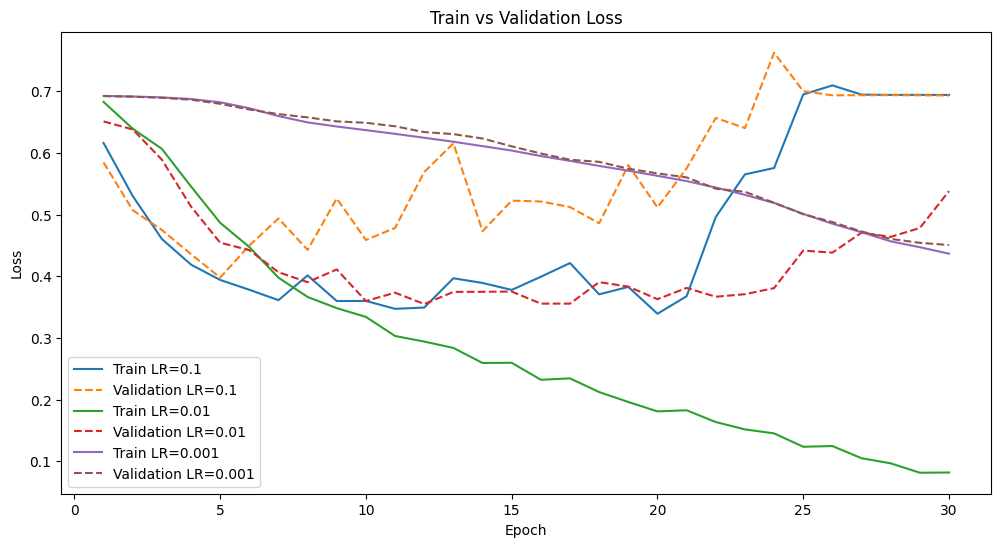

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multiple_training_curves(paths, labels):
    """
    Plots the training curve for multiple model runs, given the csv files
    containing the train/validation error/loss.

    Args:
        paths: List of base paths of the csv files produced during training
        labels: List of labels for each path for legend
    """

    plt.figure(figsize=(12, 6))
    plt.title("Train vs Validation Error")

    for path, label in zip(paths, labels):
        train_err = np.loadtxt("{}_train_err.csv".format(path))
        val_err = np.loadtxt("{}_val_err.csv".format(path))

        # Print the vectors
        print(f"Train Error for {label}: {train_err}")
        print(f"Validation Error for {label}: {val_err}")

        n = len(train_err)  # number of epochs
        plt.plot(range(1, n+1), train_err, label="Train " + label)
        plt.plot(range(1, n+1), val_err, linestyle='--', label="Validation " + label)

    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.title("Train vs Validation Loss")

    for path, label in zip(paths, labels):
        train_loss = np.loadtxt("{}_train_loss.csv".format(path))
        val_loss = np.loadtxt("{}_val_loss.csv".format(path))
        n = len(train_loss)  # number of epochs
        plt.plot(range(1, n+1), train_loss, label="Train " + label)
        plt.plot(range(1, n+1), val_loss, linestyle='--', label="Validation " + label)

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

# Example usage:
# plot_training_curve(["path1", "path2"], ["LR=0.01", "LR=0.001"])


plot_multiple_training_curves(['model_large_bs64_lr0.1_epoch29', 'model_large_bs64_lr0.01_epoch29', 'model_large_bs64_lr0.001_epoch29'],  ["LR=0.1","LR=0.01", "LR=0.001"])

### Part (iii) [0.5pt EXPLORATORY] - increasing the batch size

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

> Typically, a larger batch size leads to faster per-epoch training since there are fewer updates, but this isn't shown in the data provided. As we can see here, it took 136 seconds for the smaller batch (64) and 120 seconds for the larger one (512). With larger batch sizes, each epoch can be faster, but it might take more epochs to converge.


 > * **Generalization:** The smaller batch size (64) generalizes better to the validation set, as indicated by the lower validation error compared to the model trained with batch size 512.
* **Convergence:** The smaller batch size (64) converges to a lower training error more rapidly than the larger batch size (512).
* **Stability:** The validation error for the smaller batch size shows more fluctuations compared to the larger batch size, which might indicate that smaller batches can result in a more noisy gradient, whereas larger batches provide a more stable (averaged) gradient.

> In summary, increasing the batch size (from 64 to 512 in this case) has led to:

> * Slower convergence in terms of training error.
* Slightly worse generalization to the validation set.
* Potentially faster per-epoch training times.
* A more stable, but possibly less accurate, gradient direction (as inferred from the smoother validation error curve for the larger batch size).

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)

Train Error for LR=0.01 batch size 64: [0.446375 0.35925  0.32175  0.2665   0.233125 0.2055   0.1785   0.15975
 0.146875 0.145    0.12725  0.121875 0.1195   0.1045   0.10775  0.092625
 0.098375 0.086875 0.082625 0.0725   0.072375 0.064875 0.05775  0.05725
 0.048    0.049    0.042625 0.038125 0.03075  0.03225 ]
Validation Error for LR=0.01 batch size 64: [0.382  0.3565 0.3115 0.2545 0.216  0.202  0.1765 0.172  0.177  0.1505
 0.162  0.153  0.1565 0.157  0.1415 0.14   0.136  0.1545 0.152  0.1475
 0.147  0.136  0.1295 0.142  0.144  0.14   0.1555 0.14   0.1415 0.155 ]
Train Error for LR=0.01 batch size 512: [0.466    0.413    0.4035   0.400125 0.37375  0.364375 0.364625 0.364875
 0.36525  0.358    0.354875 0.346125 0.3455   0.3345   0.323625 0.30675
 0.302625 0.292125 0.285875 0.276125 0.260375 0.25325  0.236875 0.225625
 0.215875 0.197    0.1955   0.190375 0.183875 0.175   ]
Validation Error for LR=0.01 batch size 512: [0.44   0.403  0.3925 0.393  0.374  0.368  0.3765 0.38   0.362  0.358
 

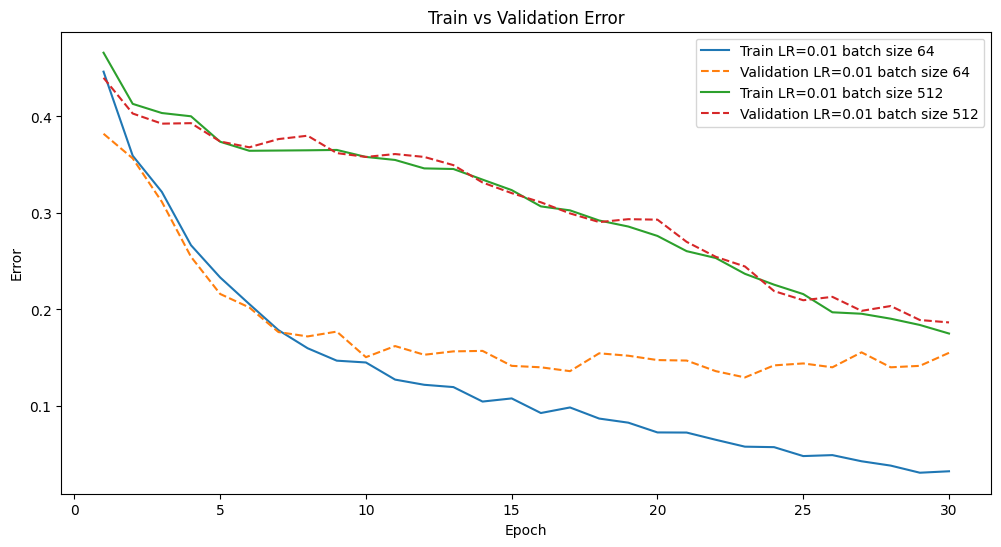

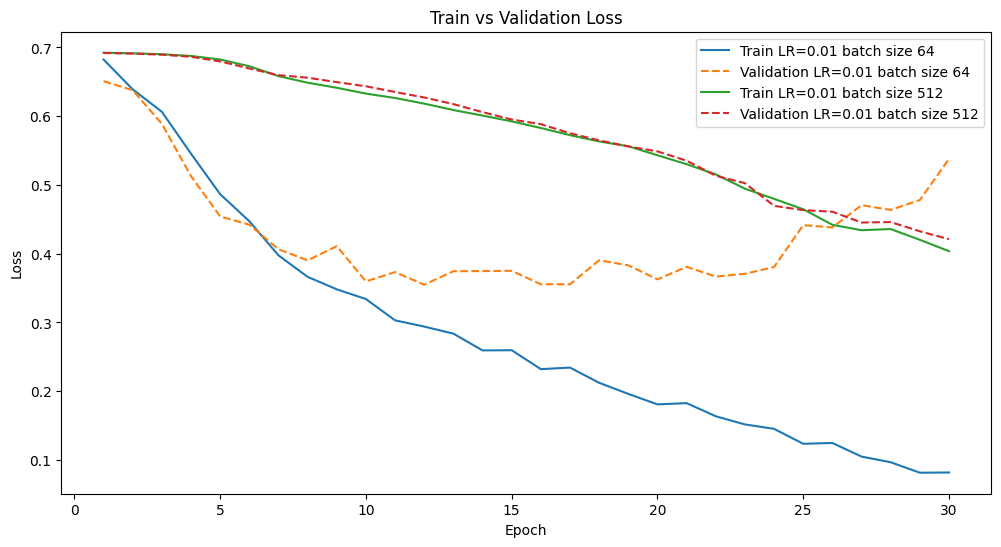

In [27]:
plot_multiple_training_curves(['model_large_bs64_lr0.01_epoch29', 'model_large_bs512_lr0.01_epoch29'],  ["LR=0.01 batch size 64","LR=0.01 batch size 512"])

### Part (iv) [0.5pt EXPLORATORY] - decreasing the batch size

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

> The batch size of 16 causes the model to plateau rapidly, indicating possible divergence or getting stuck in poor local minima. It appears that this model may be diverging or getting stuck very early in training. Both training and validation errors plateau quickly. This can be caused by the noisy gradient updates that come with very small batch sizes, which may cause the model to jump around the optimization landscape. Too large of a batch size can be slow and less generalizing, but too small can lead to instability.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)

Train Error for LR=0.01 batch size 16: [0.34475  0.22175  0.254    0.502375 0.502375 0.502375 0.502375 0.502375
 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375
 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375
 0.502375 0.502375 0.502375 0.502375 0.502375 0.502375]
Validation Error for LR=0.01 batch size 16: [0.2855 0.2    0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905
 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905
 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905 0.4905]
Train Error for LR=0.01 batch size 64: [0.446375 0.35925  0.32175  0.2665   0.233125 0.2055   0.1785   0.15975
 0.146875 0.145    0.12725  0.121875 0.1195   0.1045   0.10775  0.092625
 0.098375 0.086875 0.082625 0.0725   0.072375 0.064875 0.05775  0.05725
 0.048    0.049    0.042625 0.038125 0.03075  0.03225 ]
Validation Error for LR=0.01 batch size 64: [0.382  0.3565 0.3115 0.2545 0.216  0.202  0.1765 0.172  0.177  0.1505
 

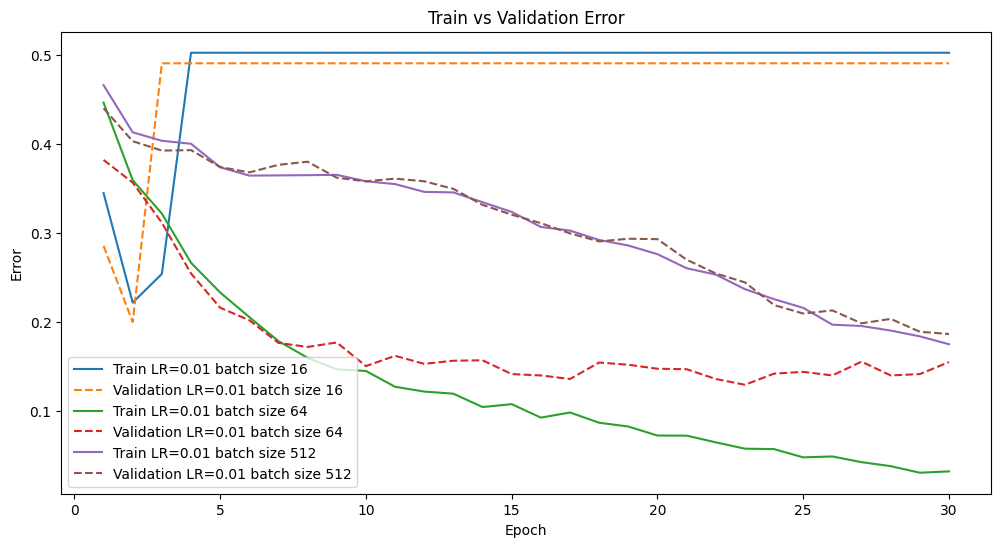

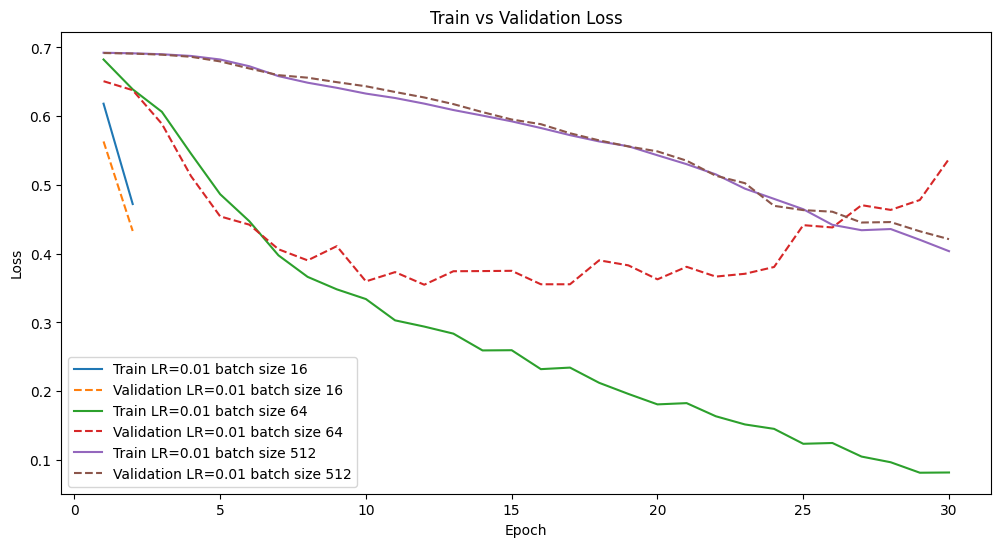

In [28]:
plot_multiple_training_curves(['model_large_bs16_lr0.01_epoch29', 'model_large_bs64_lr0.01_epoch29', 'model_large_bs512_lr0.01_epoch29'],  ["LR=0.01 batch size 16", "LR=0.01 batch size 64","LR=0.01 batch size 512"])

## Part 4. Hyperparameter Search



### Part (i) [1pt EXPLORATORY]

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.


> A **learning rate of 0.001** seemed the most effective given that 0.01 and 0.1 were both overfitting.

>  Based on the data, a **batch size of 64 seemed to be the most effective**. The model with a batch size of 16 diverged, while the one with 512 was slower to converge. The batch size of 64 had a good balance of stability and speed of convergence.

> Large net is better than Small net as it shows lower loss and error. Look at plots below.

In [29]:
def extract_data_from_dataloader(dataloader):
    data_list = []
    label_list = []

    for data, labels in dataloader:
        data_list.append(data)
        label_list.append(labels)

    X = torch.cat(data_list, 0)
    y = torch.cat(label_list, 0)
    return X, y

target_classes = ["car", "truck"]

train_loader, val_loader, test_loader, classes = get_data_loader(target_classes, batch_size=64)  # assuming get_data_loader is defined

X_train, y_train = extract_data_from_dataloader(train_loader)
X_val, y_val = extract_data_from_dataloader(val_loader)


Files already downloaded and verified
Files already downloaded and verified


In [30]:
X_test, y_test = extract_data_from_dataloader(val_loader)


In [ ]:
train_net(small_net, batch_size=64, learning_rate=0.001, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified


RuntimeError: ignored

Train Error for LR=0.001 batch size 64 Small: [0.4585   0.404    0.39125  0.390875 0.372625 0.36675  0.367375 0.364125
 0.36325  0.35925  0.355625 0.351125 0.349875 0.340875 0.33425  0.32175
 0.314375 0.30575  0.29675  0.287875 0.281875 0.274125 0.264625 0.251125
 0.239875 0.22725  0.21875  0.20975  0.205875 0.19425 ]
Validation Error for LR=0.001 batch size 64 Small: [0.4145 0.401  0.3825 0.379  0.3725 0.3745 0.3785 0.3765 0.3715 0.3675
 0.3585 0.3645 0.3525 0.3515 0.3335 0.3165 0.3135 0.305  0.304  0.292
 0.281  0.273  0.2775 0.258  0.2425 0.2235 0.213  0.2085 0.2035 0.207 ]
Train Error for LR=0.001 batch size 64 Large: [0.139125 0.13625  0.13625  0.135875 0.136125 0.135    0.135625 0.136
 0.136    0.133625 0.13525  0.13625  0.135375 0.134375 0.136375 0.133875
 0.134375 0.134375 0.133875 0.134625 0.133625 0.13375  0.134625 0.13175
 0.13675  0.131125 0.1335   0.132875 0.131125 0.1325  ]
Validation Error for LR=0.001 batch size 64 Large: [0.1675 0.173  0.167  0.169  0.174  0.166  0.165

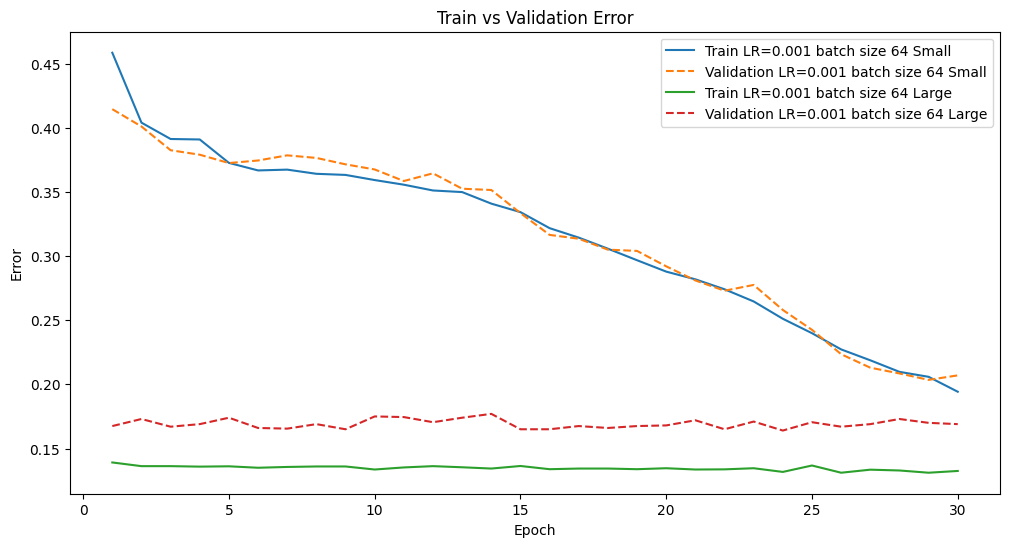

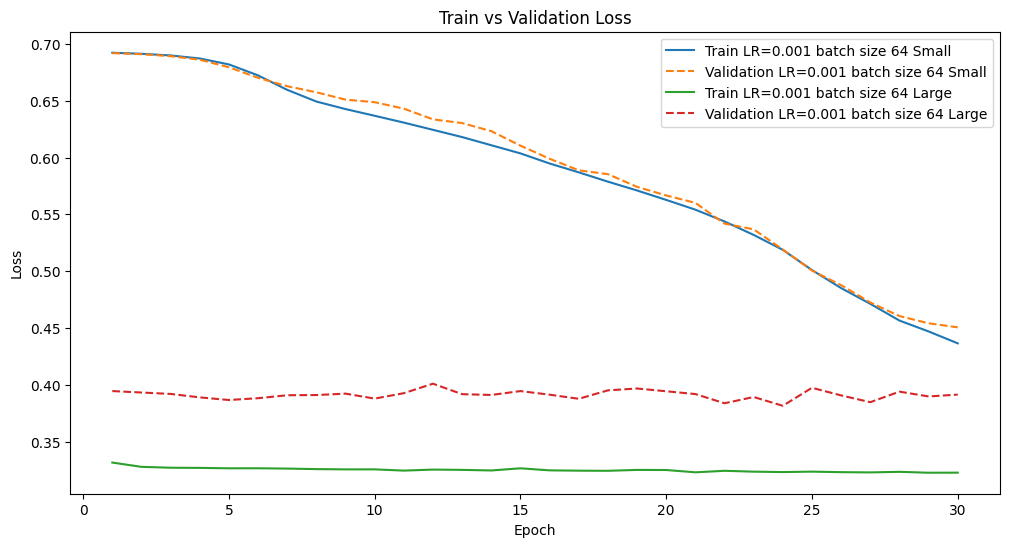

In [31]:
plot_multiple_training_curves(['model_large_bs64_lr0.001_epoch29', 'model_small_bs64_lr0.001_epoch29'],  ["LR=0.001 batch size 64 Small", "LR=0.001 batch size 64 Large"])

### Part (ii) [0.5pt EXPLORATORY]

Train the model with the hyperparameters you chose in part(i), and include the training curve.

Train Error for LR=0.001 batch size 64 Large - chosen architecture: [0.4585   0.404    0.39125  0.390875 0.372625 0.36675  0.367375 0.364125
 0.36325  0.35925  0.355625 0.351125 0.349875 0.340875 0.33425  0.32175
 0.314375 0.30575  0.29675  0.287875 0.281875 0.274125 0.264625 0.251125
 0.239875 0.22725  0.21875  0.20975  0.205875 0.19425 ]
Validation Error for LR=0.001 batch size 64 Large - chosen architecture: [0.4145 0.401  0.3825 0.379  0.3725 0.3745 0.3785 0.3765 0.3715 0.3675
 0.3585 0.3645 0.3525 0.3515 0.3335 0.3165 0.3135 0.305  0.304  0.292
 0.281  0.273  0.2775 0.258  0.2425 0.2235 0.213  0.2085 0.2035 0.207 ]


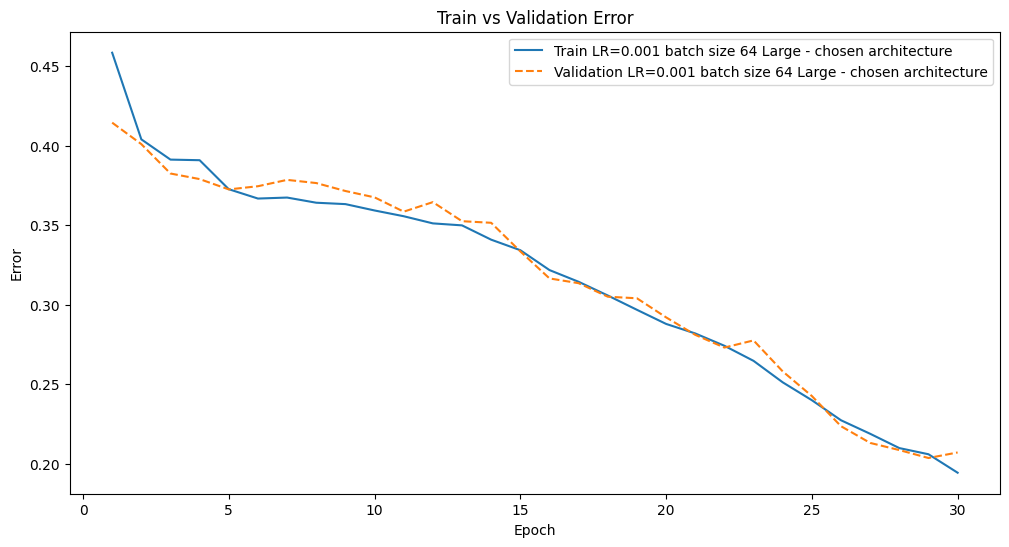

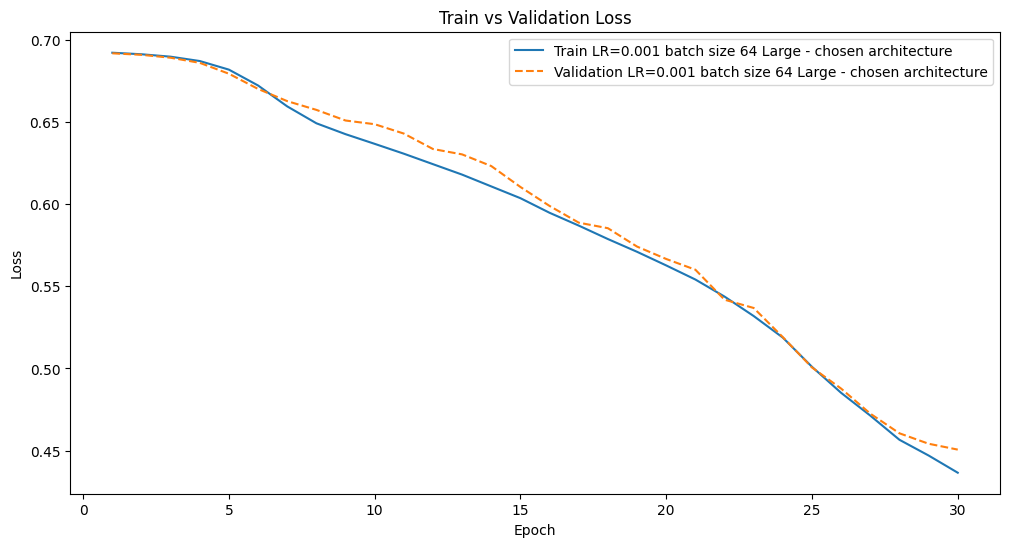

In [32]:
plot_multiple_training_curves(['model_large_bs64_lr0.001_epoch29'],  ["LR=0.001 batch size 64 Large - chosen architecture"])

### Part (iii) [1pt EXPLORATORY]
Based on your result from Part(i), suggest another set of hyperparameter values to try.
Justify your choice.

> I'd increase the number of epochs because as we can see from the chart above, the loss and error functions have not converged yet.

### Part (iv) [0.5pt EXPLORATORY] - training model with more epochs, large net, lr 0.001, batch size 64

Train the model with the hyperparameters you chose in part(iii), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=50)

Train Error for LR=0.001 batch size 64 Large - chosen architecture with many epochs: [0.497625 0.497375 0.473875 0.4345   0.38925  0.374375 0.369    0.363
 0.361125 0.356875 0.353375 0.345    0.339625 0.33525  0.323875 0.315125
 0.3045   0.2955   0.288875 0.2775   0.270875 0.266875 0.261125 0.256875
 0.247125 0.2455   0.239375 0.236125 0.232    0.2285   0.223375 0.219375
 0.216    0.21225  0.205625 0.203875 0.195    0.190625 0.189    0.181625
 0.177    0.174125 0.167375 0.161125 0.159375 0.15475  0.154625 0.146625
 0.14475  0.143375]
Validation Error for LR=0.001 batch size 64 Large - chosen architecture with many epochs: [0.5095 0.5095 0.4745 0.434  0.407  0.3915 0.391  0.3855 0.3735 0.367
 0.356  0.3525 0.3415 0.334  0.3185 0.3105 0.3015 0.285  0.283  0.274
 0.272  0.2685 0.2725 0.256  0.258  0.2585 0.253  0.252  0.2435 0.24
 0.228  0.23   0.2315 0.237  0.2245 0.209  0.2055 0.2025 0.206  0.2005
 0.195  0.196  0.185  0.183  0.1975 0.1795 0.178  0.188  0.1675 0.1645]


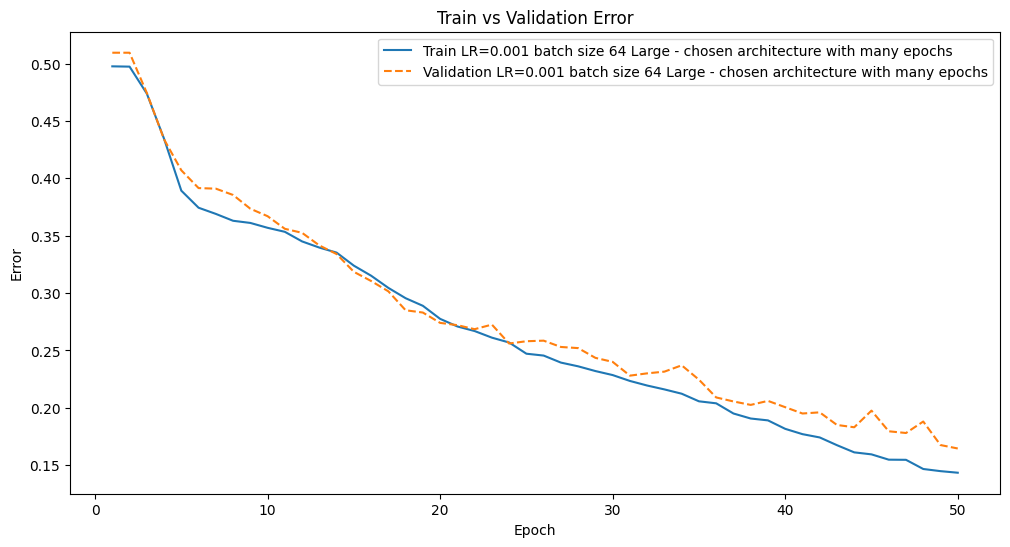

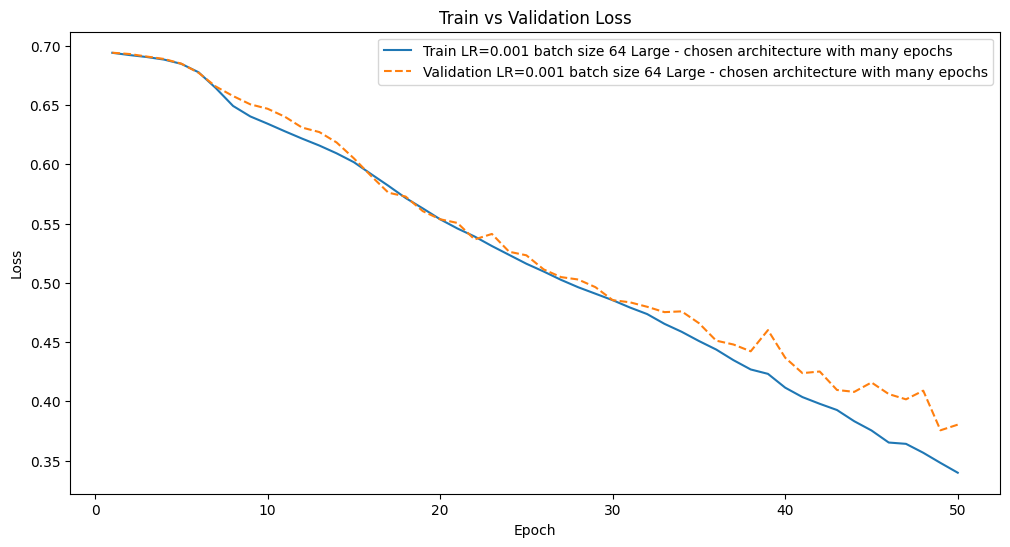

In [33]:
plot_multiple_training_curves(['model_large_bs64_lr0.001_epoch49'],  ["LR=0.001 batch size 64 Large - chosen architecture with many epochs"])

## Part 4. Evaluating the Best Model


### Part (i) [2pt MODEL] -  summarize results

Summarize in a table the results achieved on training and validation on all your model selections. This includes choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**. Hint: you can import the Pandas module to create tables.


Then upon reviewing the results choose your **best** model and load the model checkpoint. You can modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
# # Training
# def get_model_name(name, batch_size, learning_rate, epoch):
#     """ Generate a name for the model consisting of all the hyperparameter values

#     Args:
#         config: Configuration object containing the hyperparameters
#     Returns:
#         path: A string with the hyperparameter name and value concatenated
#     """
#     path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
#                                                    batch_size,
#                                                    learning_rate,
#                                                    epoch)
#     return path


In [ ]:
net = small_net
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=10)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [34]:
import pandas as pd
import numpy as np
import os

models = {
    "small_net": SmallNet(),
    "large_net": LargeNet()
}

batch_sizes = [16, 64, 512]
learning_rates = [0.1, 0.01, 0.001]
epochs_list = [30, 50]  # Adding a list containing both epoch values

results = []

for num_epochs in epochs_list:  # Loop over epochs_list
    final_epoch = num_epochs - 1

    for model_name, net in models.items():
        for batch_size in batch_sizes:
            for learning_rate in learning_rates:
                model_path = get_model_name(net.name, batch_size=batch_size,
                                            learning_rate=learning_rate, epoch=final_epoch)

                # Check if files exist
                train_err_path = "{}_train_err.csv".format(model_path)
                train_loss_path = "{}_train_loss.csv".format(model_path)
                val_err_path = "{}_val_err.csv".format(model_path)
                val_loss_path = "{}_val_loss.csv".format(model_path)

                if os.path.exists(train_err_path) and os.path.exists(train_loss_path) and \
                   os.path.exists(val_err_path) and os.path.exists(val_loss_path):

                   # Read the values from the last epoch
                   train_err = np.loadtxt(train_err_path)[-1]
                   train_loss = np.loadtxt(train_loss_path)[-1]
                   val_err = np.loadtxt(val_err_path)[-1]
                   val_loss = np.loadtxt(val_loss_path)[-1]

                   results.append({
                       "model": model_name,
                       "batch_size": batch_size,
                       "learning_rate": learning_rate,
                       "epoch": final_epoch,
                       "train_accuracy": 1-train_err,
                       "train_loss": train_loss,
                       "val_accuracy": 1-val_err,
                       "val_loss": val_loss
                   })

df = pd.DataFrame(results)
print(df)


       model  batch_size  learning_rate  epoch  train_accuracy  train_loss  \
0  small_net          64          0.010     29        0.847125    0.354911   
1  small_net          64          0.001     29        0.867500    0.322704   
2  large_net          16          0.010     29        0.497625         NaN   
3  large_net          64          0.100     29        0.499125    0.693757   
4  large_net          64          0.010     29        0.967750    0.081857   
5  large_net          64          0.001     29        0.805750    0.436488   
6  large_net         512          0.010     29        0.825000    0.403717   
7  large_net          64          0.001     49        0.856625    0.339778   

   val_accuracy  val_loss  
0        0.8220  0.409165  
1        0.8310  0.391398  
2        0.5095       NaN  
3        0.5095  0.692885  
4        0.8450  0.537919  
5        0.7930  0.450559  
6        0.8135  0.421187  
7        0.8355  0.380339  


In [35]:
df['accuracy_delta'] = df['train_accuracy'] - df['val_accuracy']
df['accuracy_avg'] = (df['train_accuracy'] + df['val_accuracy'])/2

df['loss_delta'] = df['train_loss'] - df['val_loss']
df['loss_avg'] = (df['train_loss'] + df['val_loss'])/2


df.style.bar(align='mid', color=['red', 'lightgreen'])

,model,batch_size,learning_rate,epoch,train_accuracy,train_loss,val_accuracy,val_loss,accuracy_delta,accuracy_avg,loss_delta,loss_avg
0,small_net,64,0.010000,29,0.847125,0.354911,0.822000,0.409165,0.025125,0.834563,-0.054254,0.382038
1,small_net,64,0.001000,29,0.867500,0.322704,0.831000,0.391398,0.036500,0.849250,-0.068694,0.357051
2,large_net,16,0.010000,29,0.497625,nan,0.509500,nan,-0.011875,0.503563,nan,nan
3,large_net,64,0.100000,29,0.499125,0.693757,0.509500,0.692885,-0.010375,0.504313,0.000872,0.693321
4,large_net,64,0.010000,29,0.967750,0.081857,0.845000,0.537919,0.122750,0.906375,-0.456062,0.309888
5,large_net,64,0.001000,29,0.805750,0.436488,0.793000,0.450559,0.012750,0.799375,-0.014072,0.443524
6,large_net,512,0.010000,29,0.825000,0.403717,0.813500,0.421187,0.011500,0.819250,-0.017470,0.412452
7,large_net,64,0.001000,49,0.856625,0.339778,0.835500,0.380339,0.021125,0.846062,-0.040560,0.360059


In [36]:
print(df)

       model  batch_size  learning_rate  epoch  train_accuracy  train_loss  \
0  small_net          64          0.010     29        0.847125    0.354911   
1  small_net          64          0.001     29        0.867500    0.322704   
2  large_net          16          0.010     29        0.497625         NaN   
3  large_net          64          0.100     29        0.499125    0.693757   
4  large_net          64          0.010     29        0.967750    0.081857   
5  large_net          64          0.001     29        0.805750    0.436488   
6  large_net         512          0.010     29        0.825000    0.403717   
7  large_net          64          0.001     49        0.856625    0.339778   

   val_accuracy  val_loss  accuracy_delta  accuracy_avg  loss_delta  loss_avg  
0        0.8220  0.409165        0.025125      0.834563   -0.054254  0.382038  
1        0.8310  0.391398        0.036500      0.849250   -0.068694  0.357051  
2        0.5095       NaN       -0.011875      0.503563  

In [37]:
import plotly.express as px
import pandas as pd

# Assuming your data is stored in a DataFrame named df

# Create the scatter plot
fig = px.scatter(df, x="loss_avg", y="accuracy_avg",
                 hover_data=["model", "batch_size", "learning_rate", "epoch",
                             "train_accuracy", "train_loss", "val_accuracy", "val_loss",
                             "accuracy_delta", "loss_delta"],
                 text=df.index,  # this will label each point with its index
                 title="Scatter plot of Accuracy Average vs Loss Average")

# Show the plot
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Assuming your data is stored in a DataFrame named df

# Create the scatter plot
fig = px.scatter(df, x="loss_delta", y="accuracy_delta",
                 hover_data=["model", "batch_size", "learning_rate", "epoch",
                             "train_accuracy", "train_loss", "val_accuracy", "val_loss",
                             "accuracy_avg", "loss_avg"],
                 text=df.index,  # this will label each point with its index
                 title="Scatter plot of Accuracy Average vs Loss Average")

# Show the plot
fig.show()


In [38]:
import plotly.graph_objects as go
import pandas as pd

# Assuming your data is stored in a DataFrame named df

# Create a scatter plot for the training set
trace_train = go.Scatter(
    x=df["train_loss"],
    y=df["train_accuracy"],
    mode='markers+text',
    name='Training',
    text=df.index,  # this will label each point with its index
    hoverinfo='text',
    hovertext=df.apply(lambda row: f"Model: {row['model']}, Batch size: {row['batch_size']}, Learning rate: {row['learning_rate']}, Epoch: {row['epoch']}", axis=1)
)

# Create a scatter plot for the validation set
trace_val = go.Scatter(
    x=df["val_loss"],
    y=df["val_accuracy"],
    mode='markers+text',
    name='Validation',
    text=df.index,  # this will label each point with its index
    hoverinfo='text',
    hovertext=df.apply(lambda row: f"Model: {row['model']}, Batch size: {row['batch_size']}, Learning rate: {row['learning_rate']}, Epoch: {row['epoch']}", axis=1)
)

# Layout settings and plot
layout = go.Layout(
    title="Scatter plot of Accuracy vs Loss for Training and Validation Sets",
    xaxis=dict(title="Loss"),
    yaxis=dict(title="Accuracy"),
    hovermode="closest"
)

fig = go.Figure(data=[trace_train, trace_val], layout=layout)

# Show the plot
fig.show()


Then upon reviewing the results choose your best model and load the model checkpoint. You can modify the code below to load your chosen set of weights to the model object net.

> I'd opt for the large_net model trained for 50 epochs with a batch size of 64 and a learning rate of 0.001.



### Part (ii) [4pt DISCUSSION] - justify model selection

Justify your choice of model from Part (i).

> At first, the model trained for 30 epochs with a batch size of 64 and a learning rate of 0.01 might seem superior due to its higher training accuracy. However, upon closer examination, particularly when visualized, it's evident that there's a significant gap between its training and validation performance. This larger discrepancy suggests a higher potential for overfitting.

### Part (iii) [4pt RESULT] - compute test error

Using the helper code in Part 0, any code from lecture notes, or any code that you write, compute and report the **test classification error** for your chosen model.

> I've editted the `train_net` function to do the same thing it does for train and validations sets but to do it for the test set as well.

In [52]:

def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cars vs trucks
    target_classes = ["car", "truck"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)


    test_err = np.zeros(num_epochs)
    test_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)


        test_err[epoch], test_loss[epoch] = evaluate(net, test_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {} "\
               +"Test err: {}, Test loss: {} ").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch],
                   test_err[epoch],
                   test_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        print("Model Path")
        print(model_path)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    # print("Saving files like {}_train_err.csv".format(model_path))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    np.savetxt("{}_test_err.csv".format(model_path), test_err)
    np.savetxt("{}_test_loss.csv".format(model_path), test_loss)

In [53]:
test_loader

In [54]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=50)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.496625, Train loss: 0.6918477902412414 |Validation err: 0.5065, Validation loss: 0.6908917892724276 Test err: 0.4955, Test loss: 0.690552044659853 
Model Path
model_large_bs64_lr0.001_epoch0
Epoch 2: Train err: 0.4605, Train loss: 0.6877958827018738 |Validation err: 0.4265, Validation loss: 0.6859889645129442 Test err: 0.4235, Test loss: 0.6847101598978043 
Model Path
model_large_bs64_lr0.001_epoch1
Epoch 3: Train err: 0.388875, Train loss: 0.6803219232559204 |Validation err: 0.3965, Validation loss: 0.6758222114294767 Test err: 0.3895, Test loss: 0.6737691890448332 
Model Path
model_large_bs64_lr0.001_epoch2
Epoch 4: Train err: 0.371375, Train loss: 0.6647109742164612 |Validation err: 0.3765, Validation loss: 0.6582244504243135 Test err: 0.3695, Test loss: 0.6540019176900387 
Model Path
model_large_bs64_lr0.001_epoch3
Epoch 5: Train err: 0.361, Train loss: 0.6450635571479797 |Validation e

In [57]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    test_err = np.loadtxt("{}_test_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    test_loss = np.loadtxt("{}_test_loss.csv".format(path))

    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.plot(range(1,n+1), test_err, label="Test")

    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train, Validation, and Test Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.plot(range(1,n+1), test_loss, label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

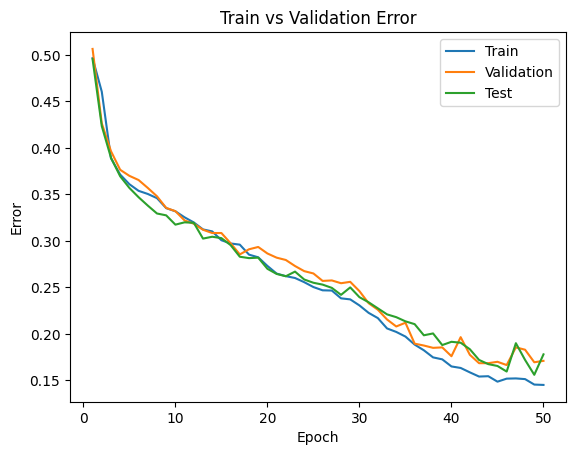

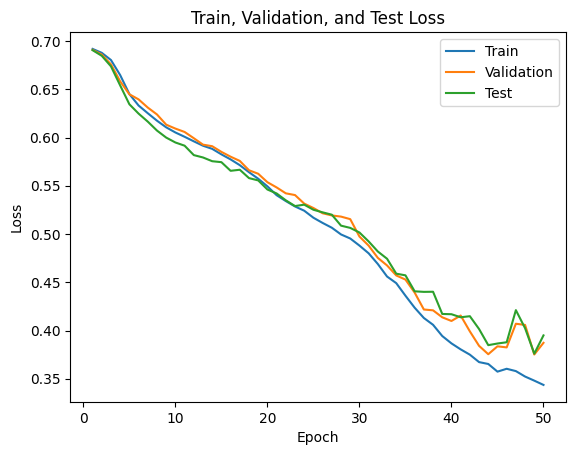

In [58]:
plot_training_curve('model_large_bs64_lr0.001_epoch49')

### Part (iv) [3pt DISCUSSION] - validation vs test error

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

> Both the error and the loss plots between validation and test sets are very comparable so there's no evident sign of significant overfitting. The error on the test set could be slightly higher than the validation error because there was information leak when doing hyperparameter tuning to favor the validation set and therefore decrease the error in it. In other words, if the validation set is used extensively in the tuning process (e.g., through many rounds of hyperparameter optimization), the model could overfit to the validation set.

> Validation error is often used to select the "best" model from several candidates. When you make this selection based on the validation error, you're inherently selecting a model that has, by chance or by actual merit, performed well on the validation set. However, this performance might not carry over to the test set as effectively.

### Part (v) [3pt DISCUSSION] - why only use test set at the end
Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

> The primary purpose of test data is to provide an unbiased evaluation of the final model. It gives us a sense of how well the model will perform when presented with new, unseen data. If we use the testing set to tune the hyperparameters there can be leak information leak and therefore provide an irrealistic view of the performance on genuinely unseen data. We can bias the model to make it "fit" or increase the performance on the test set if we were to use it as well, therefore, the expected performance would be artificially inflated and overly confident.

## Part 5. Fully-Connected Linear ANN vs CNN [4pt RESULT]

Test out a 3-layer linear fully-connected ANN architecture (see simpleANN below). You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

How does the your best CNN model compare with an 2-layer linear ANN model (no convolutional layers) on classifying car and truck images?

In [59]:
class simpleANN(nn.Module):
    def __init__(self):
        super(simpleANN, self).__init__()
        self.name = "simple"
        self.fc1 = nn.Linear(32*32*3, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [61]:
simple_ann = simpleANN()
simple_ann


simpleANN(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=1, bias=True)
)

In [81]:
def train_net_no_test_set(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cars vs trucks
    target_classes = ["car", "truck"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        print("Model Path")
        print(model_path)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    # print("Saving files like {}_train_err.csv".format(model_path))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


def plot_training_curve_no_test_set(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")

    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train, Validation, and Test Loss")
    print(f"train_loss:{train_loss}")
    print(f"val_loss:{val_loss}")


    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [70]:
train_net_no_test_set(simple_ann, batch_size=64, learning_rate=0.001, num_epochs=50)

'model_simple_bs64_lr0.001_epoch49'

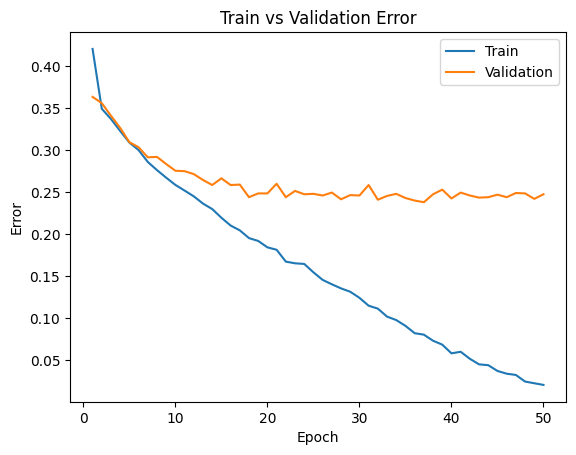

train_loss:[0.67275092 0.63369024 0.61407331 0.60011064 0.58750792 0.57425386
 0.56206678 0.54965025 0.53752718 0.52571614 0.51631877 0.50431855
 0.49346128 0.48373578 0.47131587 0.46165386 0.45005428 0.43947345
 0.42962782 0.41959713 0.40759537 0.3955487  0.38252934 0.37723472
 0.36179176 0.34774326 0.3382007  0.32831876 0.3164389  0.30468537
 0.29259842 0.28084255 0.26591381 0.25939905 0.24449169 0.23014648
 0.22312056 0.21006434 0.19639169 0.18585919 0.17971764 0.16535412
 0.15068868 0.14382635 0.13449778 0.12554167 0.12270033 0.10478644
 0.097372   0.08988049]
val_loss:[0.64882327 0.62573643 0.61220858 0.60664656 0.59317352 0.58705759
 0.57649328 0.56864539 0.55607928 0.54957092 0.55262879 0.54376123
 0.53250183 0.52789    0.53347517 0.52372705 0.52082859 0.51597342
 0.50997798 0.51883384 0.51612331 0.50969854 0.51211016 0.52048422
 0.50897591 0.5108156  0.51904242 0.51997851 0.53145792 0.52431554
 0.5577384  0.5189967  0.5450077  0.54418644 0.5615626  0.58702791
 0.56359253 0.5816

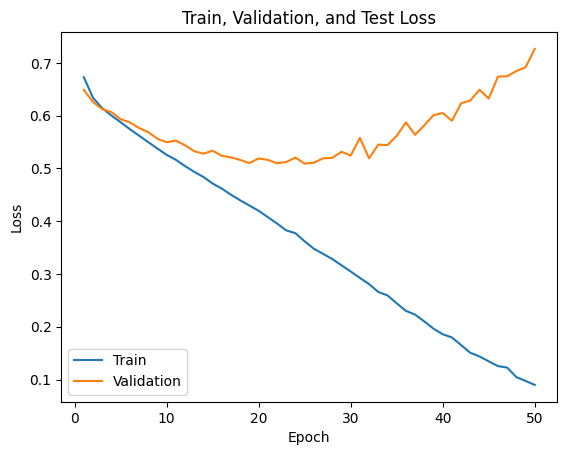

In [82]:
plot_training_curve_no_test_set(get_model_name(simple_ann.name, 64, 0.001, 49))

In [76]:
class simpleANNv2(nn.Module):
    def __init__(self):
        super(simpleANNv2, self).__init__()
        self.name = "simple_v2"


        self.fc1 = nn.Linear(32*32*3, 80)
        self.fc2 = nn.Linear(80, 10)
        self.fc3 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm1d(80)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.dropout(self.bn1(F.relu(self.fc1(x))))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x




In [77]:
simple_ann_v2 = simpleANNv2()

In [79]:
train_net_no_test_set(simple_ann_v2, batch_size=64, learning_rate=0.01, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.366375, Train loss: 0.6330744805335998 |Validation err: 0.353, Validation loss: 0.6193702965974808
Model Path
model_simple_v2_bs64_lr0.01_epoch0
Epoch 2: Train err: 0.31525, Train loss: 0.5949056448936463 |Validation err: 0.322, Validation loss: 0.5981087479740381
Model Path
model_simple_v2_bs64_lr0.01_epoch1
Epoch 3: Train err: 0.296875, Train loss: 0.5792337598800659 |Validation err: 0.3225, Validation loss: 0.5905856508761644
Model Path
model_simple_v2_bs64_lr0.01_epoch2
Epoch 4: Train err: 0.286875, Train loss: 0.559633770942688 |Validation err: 0.312, Validation loss: 0.5936892917379737
Model Path
model_simple_v2_bs64_lr0.01_epoch3
Epoch 5: Train err: 0.27025, Train loss: 0.5504571676254273 |Validation err: 0.2985, Validation loss: 0.5865523125976324
Model Path
model_simple_v2_bs64_lr0.01_epoch4
Epoch 6: Train err: 0.263875, Train loss: 0.5374470646381379 |Validation err: 0.29, Valida

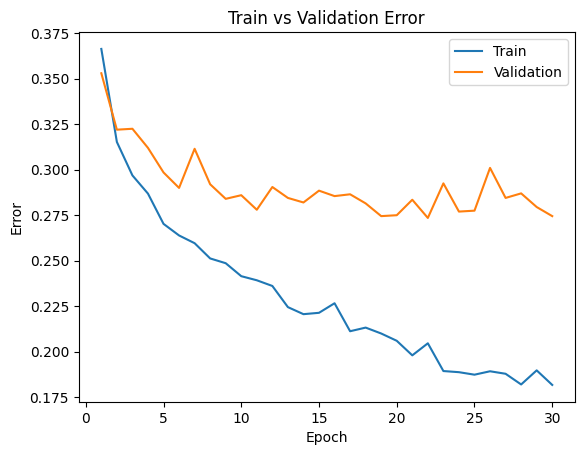

train_loss:[0.63307448 0.59490564 0.57923376 0.55963377 0.55045717 0.53744706
 0.53794021 0.52125401 0.51652657 0.50078334 0.50507044 0.49145829
 0.48938071 0.48198002 0.47920137 0.48253244 0.46271749 0.4717842
 0.45433141 0.4454762  0.44405509 0.44700392 0.42925428 0.43230527
 0.42077289 0.43249119 0.42709036 0.41014113 0.41921473 0.41717408]
val_loss:[0.6193703  0.59810875 0.59058565 0.59368929 0.58655231 0.57637495
 0.59099428 0.57618665 0.58781712 0.57485745 0.55935766 0.58017443
 0.58385726 0.56456904 0.57044956 0.58992006 0.60464081 0.60000839
 0.58164663 0.58096556 0.59583271 0.61126725 0.61746533 0.62345458
 0.63190207 0.61410981 0.60271171 0.62954377 0.62515552 0.59914763]


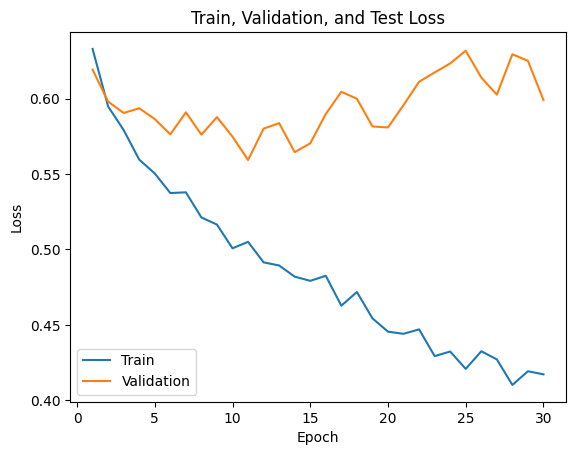

In [83]:
plot_training_curve_no_test_set(get_model_name(simple_ann_v2.name, 64, 0.01, 29))

In [84]:
import torch.nn as nn
import torch.nn.functional as F

class simpleANNv3(nn.Module):
    def __init__(self):
        super(simpleANNv3, self).__init__()

        # Input layer: 32*32*3
        self.fc1 = nn.Linear(32*32*3, 512)

        # Hidden layers
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)

        # Output layer
        self.fc5 = nn.Linear(64, 1)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.view(-1, 32*32*3)

        x = self.dropout(self.bn1(F.relu(self.fc1(x))))
        x = self.dropout(self.bn2(F.relu(self.fc2(x))))
        x = self.dropout(self.bn3(F.relu(self.fc3(x))))
        x = self.dropout(self.bn4(F.relu(self.fc4(x))))

        x = self.fc5(x)

        x = x.squeeze(1)  # Flatten to [batch_size]
        return x


In [85]:
simple_ann_v3 = simpleANNv3()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.17375, Train loss: 0.39590171360969545 |Validation err: 0.2785, Validation loss: 0.6421402674168348
Model Path
model_simple_v2_bs64_lr0.01_epoch0
Epoch 2: Train err: 0.175625, Train loss: 0.4011226484775543 |Validation err: 0.29, Validation loss: 0.6162507347762585
Model Path
model_simple_v2_bs64_lr0.01_epoch1
Epoch 3: Train err: 0.1715, Train loss: 0.389138934135437 |Validation err: 0.2905, Validation loss: 0.6585347959771752
Model Path
model_simple_v2_bs64_lr0.01_epoch2
Epoch 4: Train err: 0.166, Train loss: 0.3775297473669052 |Validation err: 0.3075, Validation loss: 0.6607649167999625
Model Path
model_simple_v2_bs64_lr0.01_epoch3
Epoch 5: Train err: 0.171, Train loss: 0.3804121119976044 |Validation err: 0.2955, Validation loss: 0.6808013608679175
Model Path
model_simple_v2_bs64_lr0.01_epoch4
Epoch 6: Train err: 0.16775, Train loss: 0.37768354964256284 |Validation err: 0.287, Validation

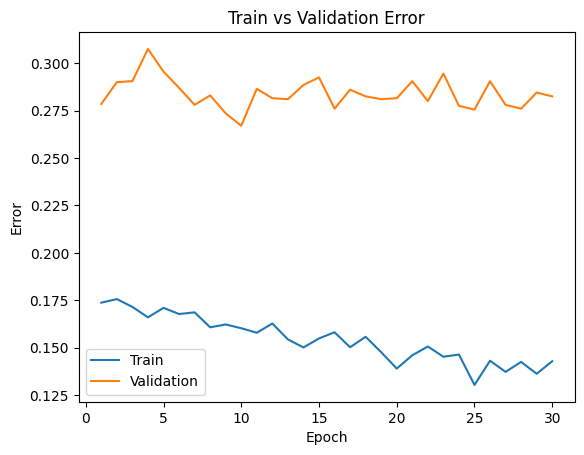

train_loss:[0.39590171 0.40112265 0.38913893 0.37752975 0.38041211 0.37768355
 0.38602129 0.36917314 0.36743132 0.36344517 0.36212135 0.36358119
 0.36048183 0.34450551 0.36180235 0.35883255 0.34943531 0.35347637
 0.33532137 0.32305714 0.33589523 0.34499685 0.32795805 0.34149079
 0.30997575 0.33230705 0.32476159 0.32414225 0.3217712  0.33827566]
val_loss:[0.64214027 0.61625073 0.6585348  0.66076492 0.68080136 0.67568993
 0.65476209 0.665488   0.70225194 0.67567389 0.66513409 0.65637641
 0.67678526 0.69648564 0.67498094 0.67920073 0.70396036 0.69019628
 0.69444575 0.77834278 0.70534837 0.75578182 0.74265203 0.71599517
 0.76552945 0.70780406 0.70904513 0.74077825 0.7501862  0.68627987]


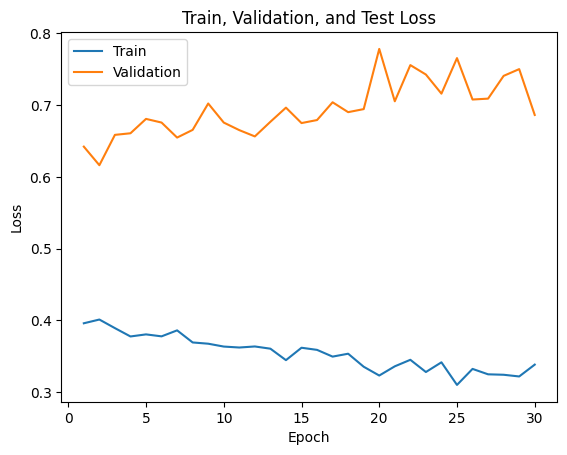

In [86]:
train_net_no_test_set(simple_ann_v2, batch_size=64, learning_rate=0.01, num_epochs=30)
plot_training_curve_no_test_set(get_model_name(simple_ann_v2.name, 64, 0.01, 29))

In [92]:
import torch.nn as nn
import torch.nn.functional as F

class simpleANNv4(nn.Module):
    def __init__(self):
        super(simpleANNv4, self).__init__()
        self.name = "simpleANNv4"

        self.fc1 = nn.Linear(32*32*3, 60)
        self.fc2 = nn.Linear(60, 10)
        self.fc3 = nn.Linear(10, 1)

        # Increased dropout
        self.dropout = nn.Dropout(0.6)
        self.bn1 = nn.BatchNorm1d(60)

    def forward(self, x):
        x = x.view(-1, 32*32*3)
        x = self.dropout(self.bn1(F.relu(self.fc1(x))))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x

def train_net_no_test_set_v4(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cars vs trucks
    target_classes = ["car", "truck"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001)
    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        print("Model Path")
        print(model_path)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    # print("Saving files like {}_train_err.csv".format(model_path))
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.3825, Train loss: 0.6561517233848572 |Validation err: 0.3655, Validation loss: 0.655378071591258
Model Path
model_simpleANNv4_bs64_lr0.01_epoch0
Epoch 2: Train err: 0.354125, Train loss: 0.6320054731369018 |Validation err: 0.3775, Validation loss: 0.6470732614398003
Model Path
model_simpleANNv4_bs64_lr0.01_epoch1
Epoch 3: Train err: 0.353125, Train loss: 0.6314754762649536 |Validation err: 0.354, Validation loss: 0.6326381023973227
Model Path
model_simpleANNv4_bs64_lr0.01_epoch2
Epoch 4: Train err: 0.350875, Train loss: 0.6370660700798034 |Validation err: 0.342, Validation loss: 0.6300054024904966
Model Path
model_simpleANNv4_bs64_lr0.01_epoch3
Epoch 5: Train err: 0.345875, Train loss: 0.6304405775070191 |Validation err: 0.3505, Validation loss: 0.6337553318589926
Model Path
model_simpleANNv4_bs64_lr0.01_epoch4
Epoch 6: Train err: 0.342875, Train loss: 0.6293405823707581 |Validation err: 0

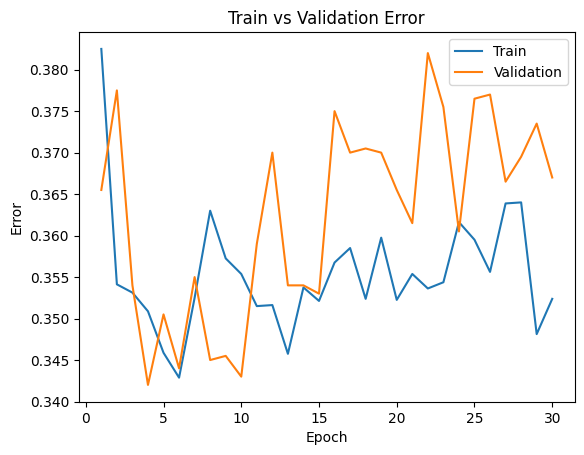

train_loss:[0.65615172 0.63200547 0.63147548 0.63706607 0.63044058 0.62934058
 0.63542134 0.6403015  0.63108678 0.63573711 0.63520836 0.63996299
 0.63350098 0.63476419 0.63382322 0.6388499  0.63596742 0.63711733
 0.63856873 0.63360784 0.63980086 0.63306947 0.63616436 0.64182594
 0.63846087 0.63615316 0.6402117  0.63816142 0.63393805 0.63424899]
val_loss:[0.65537807 0.64707326 0.6326381  0.6300054  0.63375533 0.63026181
 0.6370299  0.63341909 0.64032101 0.62804837 0.63340381 0.64595629
 0.62817304 0.64026483 0.63529775 0.6454607  0.64983848 0.64520537
 0.64326327 0.62923824 0.64452621 0.64194103 0.65068115 0.65367959
 0.64871973 0.64396775 0.63704422 0.64029451 0.64378504 0.64284071]


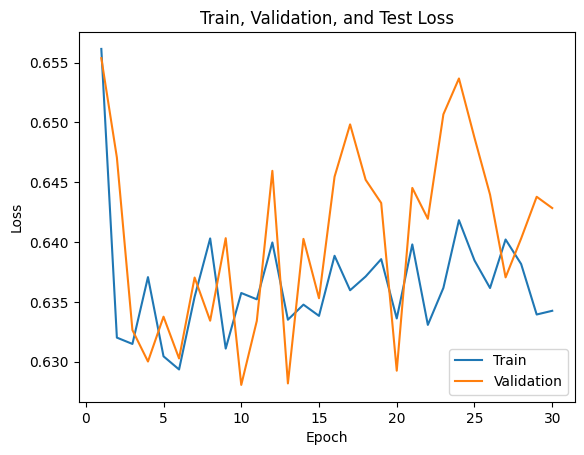

In [93]:
simple_ann_v4 = simpleANNv4()

train_net_no_test_set_v4(simple_ann_v4, batch_size=64, learning_rate=0.001, num_epochs=30)
plot_training_curve_no_test_set(get_model_name(simple_ann_v4.name, 64, 0.01, 29))

### How does the your best CNN model compare with an 2-layer linear ANN model (no convolutional layers) on classifying car and truck images?

> Even after significant adjustments (four different versions including multiple aspects of regularization, dropout, change of optimizer, change of learning rate, etc), the model gets to a point where it isn't necessarily overfitting (training and validation losses in the same ballpark) but the model isn't improving much either. Both the training and validation losses are hovering around the same range after the initial epochs. The training loss decreases slightly and then fluctuates arounf the same value, while the validation loss shows a slight increase in the later epochs. This could indicate that the model might have reached its capacity or it's stuck in a local minimum.


> CNNs are far more parameter-efficient than MLPs for image tasks. This is because CNNs use shared weights across the spatial dimensions of the input. In contrast, MLPs will treat each pixel as an independent feature, resulting in a much larger number of parameters, especially for large images. For example, for a  32 x 32 x 3 image (like CIFAR-10 images), the first hidden layer of an MLP with 100 neurons would have  32 x 32 x 3 x100=307,200 parameters, excluding biases. A CNN with a similar-sized kernel would have drastically fewer parameters.

> CNNs, with their multiple layers of convolution and pooling, naturally learn hierarchical features. Early layers might capture edges, the middle layers capture textures and patterns, and deeper layers might capture more complex structures. MLPs can also learn hierarchical features in theory, but they might not be as spatially structured or interpretable. Owing to the above reasons, CNNs generally generalize better than MLPs on image tasks when trained on limited data. They exploit the spatial structure of the data to reduce the chance of overfitting.